## Imports

In [1]:
import os
import sys
import numpy as np
import time
import scipy
import matplotlib.pyplot as plt
import time
from scipy.stats import binned_statistic

In [2]:
# import the frank2d directory
current_dir =  os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(parent_dir)

#frank2d
from frank2d import Frank2D
from constants import rad_to_arcsec
from plot import Plot
from fitting import IterativeSolverMethod

# frank1d
import frank
from frank.geometry import FixedGeometry, SourceGeometry, FitGeometryGaussian
from frank.radial_fitters import FrankFitter
from frank.utilities import UVDataBinner

### Functions

In [3]:
def deproject(u, v, inc, PA, inverse=False):
    r"""
    Deproject the image in visibily space

    Parameters
    ----------
    u : array of real, size = N, unit = :math:`\lambda`
        u-points of the visibilities
    v : array of real, size = N, unit = :math:`\lambda`
        v-points of the visibilities
    inc : float, unit = deg
        Inclination
    PA : float, unit = deg
        Position angle, defined east of north.
    inverse : bool, default=False
        If True, the uv-points are reprojected rather than deprojected

    Returns
    -------
    up : array, size = N, unit = :math:`\lambda`
        Deprojected u-points
    vp : array, size = N, unit = :math:`\lambda`
        Deprojected v-points
    wp : array of real, size = N, unit = :math:`\lambda`
        Fourier w-points of the deprojected visibilities. Only returned if
        deprojecting.

    """
    deg_to_rad = np.pi / 180
    inc *= deg_to_rad
    PA *= deg_to_rad

    cos_t = np.cos(PA)
    sin_t = np.sin(PA)

    if inverse:
        sin_t *= -1
        u = u / np.cos(inc)

    up = u * cos_t - v * sin_t
    vp = u * sin_t + v * cos_t

    if inverse:
        return up, vp
    else:
    #   Deproject
        wp = up * np.sin(inc)
        up = up * np.cos(inc)

        return up, vp, wp

In [4]:
 def apply_correction(self, u, v, V, use3D=False):
        r"""
        Correct the phase centre and deproject the visibilities

        Parameters
        ----------
        u : array of real, size = N, unit = :math:`\lambda`
            u-points of the visibilities
        v : array of real, size = N, unit = :math:`\lambda`
            v-points of the visibilities
        V : array of real, size = N, units = Jy
            Complex visibilites
        use3D : bool, default=False
            If True, also return the 3rd compoent of the
            de-projected visibilities, wp.

        Returns
        -------
        up : array of real, size = N, unit = :math:`\lambda`
            Corrected u-points of the visibilities
        vp : array of real, size = N, unit = :math:`\lambda`
            Corrected v-points of the visibilities
        wp : array of real, size = N, unit = :math:`\lambda`
            [Optional] Corrected w-points of the visibilities
        Vp : array of real, size = N, unit = Jy
            Corrected complex visibilites

        """
        Vp = apply_phase_shift(u, v, V, self._dRA, self._dDec, inverse=True)
        up, vp, wp = deproject(u, v, self._inc, self._PA)

        if use3D:
            return up, vp, wp, Vp
        else:
            return up, vp, Vp

In [5]:
def get_radial_profile(frank_object):
    x = frank_object._FT._Xn*rad_to_arcsec
    y = frank_object._FT._Yn*rad_to_arcsec
    pixel_size = (x[1]-x[0])
    r = np.hypot(x, y)
    I = frank_object.sol_intensity
    r = r.flatten()
    I = I.flatten()
    N = frank_object._Nx
    bin = (np.max(r) - np.min(r))/N
    I_binned, bin_edges, _ = binned_statistic(r, I, 'mean', N)
    r_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return r_centers, I_binned

def get_vis_profile(frank_object):
    u = frank_object._FT._Un
    v = frank_object._FT._Vn
    pixel_size = (u[1]-u[0])
    q = np.hypot(u, v)
    Vis = frank_object.sol_visibility
    q = q.flatten()
    Vis = Vis.flatten()
    N = frank_object._Nx
    bin = (np.max(q) - np.min(q))/N
    weights_gridded = frank_object._gridded_data['weights']
    Vis_binned, bin_edges, _ = binned_statistic(q, Vis, 'mean', N)
    Vis_Weights_binned, bin_edges, _ = binned_statistic(q, Vis*weights_gridded, 'sum', N)
    Weights_binned, bin_edges, _ = binned_statistic(q, weights_gridded, 'sum', N)
    q_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return q_centers, Vis_Weights_binned/Weights_binned

### Data

In [6]:
# Huang 2018 
inc = 34.97
pa = 85.76
dra = 1.9e-3
ddec = -2.5e-3
Rout = 2 #arcsecs

# UVtable
dir = "../../../data/"
data_file = dir +'AS209_continuum_prom_1chan_30s_keepflagsFalse.txt'

 # load data||
u, v, Re, Imag, Weights = np.loadtxt(data_file, unpack = True)
Vis = Re + Imag*1j

geom = SourceGeometry(inc= inc, PA= pa, dRA= dra, dDec= ddec)
u_deproj, v_deproj, vis_deproj = geom.apply_correction(u, v, Vis)

In [7]:
N = 50

In [10]:
frank2d = Frank2D(N, Rout, geometry = [inc, pa, dra, ddec])

In [11]:
u_ft = frank2d._FT._Un
v_ft = frank2d._FT._Vn
u1, u2 = np.meshgrid(u_ft, u_ft)
v1, v2 = np.meshgrid(v_ft, v_ft)
q = np.sqrt((u1-u2)**2 + (v1-v2)**2)
q_f = q.flatten()

input = [u_ft, v_ft]

## Kernel in polar coordinates

### SE

In [12]:
def factorSE_kernel(m = -0.33, c = -0.1):
    q1 = np.hypot(u1, v1)
    q2 = np.hypot(u2, v2)
    min_freq = v_ft[1]
    print(min_freq)

    def power_spectrum(q, m, c):
        q[q == 0] = min_freq
        return (q**m)* np.exp(c)

    p1 = power_spectrum(q1, m, c)
    p2 = power_spectrum(q2, m, c)
    
    factor = np.sqrt(p1 * p2)
    return factor

In [107]:
def SE_kernel( m = -0.33, c = -0.1, l = 1e5): 
    SE_Kernel = np.exp(-0.5*((u1-u2)**2 + (v1-v2)**2)/ l**2) #*  factorSE_kernel()
    return SE_Kernel

In [134]:
matrixSE = SE_kernel()

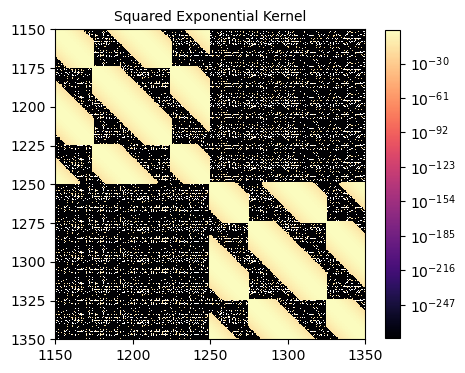

In [130]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(5,5))
plt.imshow(matrixSE, cmap =  'magma', norm=LogNorm())
plt.colorbar(shrink=0.8)
plt.xlim(1150, 1350)
plt.ylim(1350, 1150)
plt.title(r'Squared Exponential Kernel', size = 10)
plt.show()

In [257]:
def SE_kernel_radial( m = -0.33, c = -0.1, l = 1e5, k=2*np.pi): 
    r2 = (u1-u2)**2 + (v1-v2)**2
    #print(np.max(np.sqrt(r2))/l)
    o2 = (np.arctan2(v2, u2) - np.arctan2(v1, u1))**2
    #print(np.max(np.sqrt(o2))/(np.pi/20))
    SE_Kernel = np.exp(-0.5*(r2/ l**2  + o2/ k**2))#*  factorSE_kernel()

    return SE_Kernel

In [255]:
matrixSE_radial = SE_kernel_radial(k = np.pi/20)

35.733554588275545
39.74548777304017


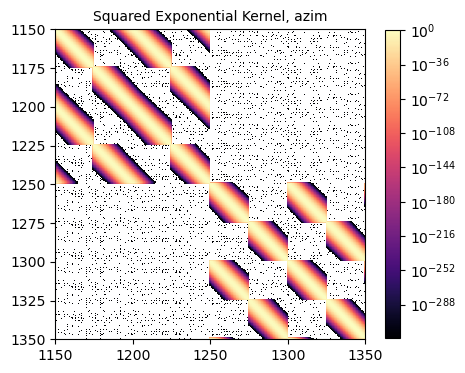

In [258]:
plt.figure(figsize=(5,5))
plt.imshow(matrixSE_radial, cmap =  'magma', norm=LogNorm())
plt.colorbar(shrink=0.8)
plt.xlim(1150, 1350)
plt.ylim(1350, 1150)
plt.title(r'Squared Exponential Kernel, azim', size = 10)
plt.show()

In [259]:
es_simetrica = np.array_equal(matrixSE_radial, matrixSE_radial.T)
es_simetrica

True

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_26362/3492938419.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(matrixSE_radial- matrixSE)), cmap =  'magma')


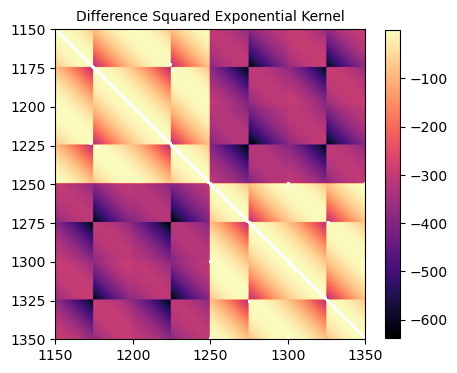

In [260]:
plt.figure(figsize=(5,5))
plt.imshow(np.log(np.abs(matrixSE_radial- matrixSE)), cmap =  'magma')
plt.colorbar(shrink=0.8)
plt.xlim(1150, 1350)
plt.ylim(1350, 1150)
plt.title(r'Difference Squared Exponential Kernel', size = 10)
plt.show()

In [264]:
l = 1e5
k = np.pi/20

In [265]:
# SE Kernel
matrixSE = SE_kernel(l = l)
matrixSE_f = (matrixSE).flatten()

matrixSE_radial = SE_kernel_radial(l = l, k = k)
matrixSE_radial_f = (matrixSE_radial).flatten()

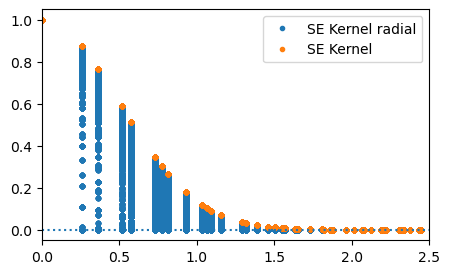

In [266]:
plt.figure(figsize=(5,3))
plt.plot(q_f/(2*l), matrixSE_radial_f, ls = 'None', marker = '.', label = 'SE Kernel radial')
plt.plot(q_f/(2*l), matrixSE_f, ls = 'None', marker = '.', label = 'SE Kernel')
plt.xlim(0, 2.5)
plt.axhline(0, ls= ':')
#plt.yscale('log')
plt.legend(loc = 'best')
plt.show()

### Wendland

In [267]:
def P_k(r, k):
    if k == 0:
        return np.ones_like(r)  # P_0(r) = 1
    elif k == 1:
        return 4*r +1  # P_1(r) = 4r + 1
    elif k == 2:
        return (35/3)*r**2 +6*r + 1  # P_2(r) = 35r^2 + 18r + 3
    else:
        raise ValueError("k must be 0, 1, or 2.")

In [268]:
def Wendland_kernel(amplitude, H, threshold = 1, j = 4, k = 1):
    r = np.sqrt((u1-u2)**2 + (v1-v2)**2)
    r_normalized = r/H
    factor = (1 - r_normalized)**j
    factor[r_normalized > threshold] = 0
    
    print(r' type?:  ϕ_{', j-k,',',  k, '}')

    return  amplitude * factor * P_k(r_normalized, k)

In [276]:
def Wendland_kernel_radial(amplitude, H1, H2, threshold = 1, j = 4, k = 1):
    r = np.sqrt((u1-u2)**2 + (v1-v2)**2)
    theta = np.abs(np.arctan2(v1, u1)- np.arctan2(v2, u2))
    
    r_normalized = r/H1
    theta_normalized = theta/H2
    factor = (1 - (r_normalized + theta_normalized))**j
    factor[(r_normalized + theta_normalized) > threshold] = 0
    
    print(r' type?:  ϕ_{', j-k,',',  k, '}')
    return  amplitude * factor * P_k(r_normalized, k)

In [277]:
matrixW = Wendland_kernel(1, 1e4)

 type?:  ϕ_{ 3 , 1 }


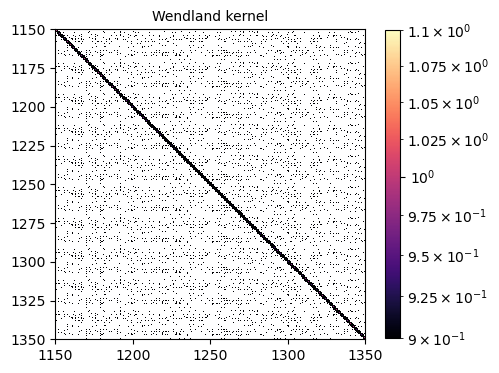

In [272]:
plt.figure(figsize=(5,5))
plt.imshow(matrixW, cmap =  'magma', norm=LogNorm())
plt.colorbar(shrink=0.8)
plt.xlim(1150, 1350)
plt.ylim(1350, 1150)
plt.title(r'Wendland kernel', size = 10)
plt.show()

In [278]:
matrixW_radial = Wendland_kernel_radial(1, 1e4, k)

 type?:  ϕ_{ 3 , 1 }


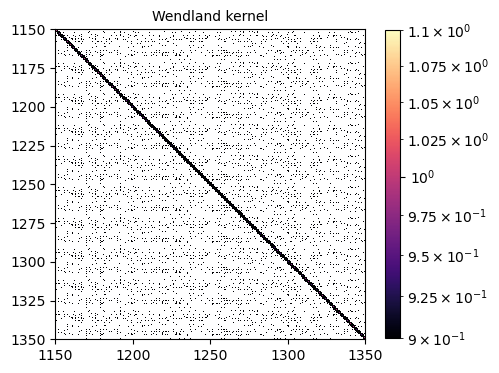

In [279]:
plt.figure(figsize=(5,5))
plt.imshow(matrixW_radial, cmap =  'magma', norm=LogNorm())
plt.colorbar(shrink=0.8)
plt.xlim(1150, 1350)
plt.ylim(1350, 1150)
plt.title(r'Wendland kernel', size = 10)
plt.show()

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_26362/1522752171.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(matrixW_radial - matrixW)) , cmap =  'magma', vmin = 0, vmax = 0.00025)


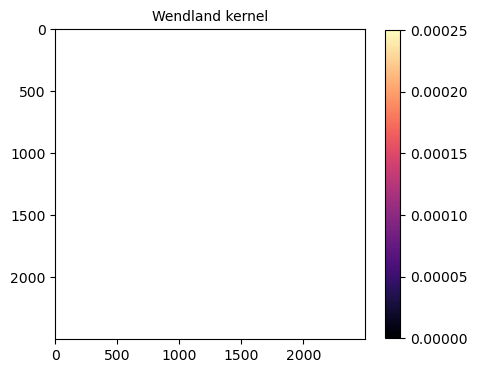

In [275]:
plt.figure(figsize=(5,5))
plt.imshow(np.log(np.abs(matrixW_radial - matrixW)) , cmap =  'magma', vmin = 0, vmax = 0.00025)
plt.colorbar(shrink=0.8)
plt.title(r'Wendland kernel', size = 10)
plt.show()

# Frank2D

In [21]:
N = 100
m, c, l, k  = -0.33, -0.1, 1e5, np.pi/100

In [ ]:
start_time = time.time()

#####

frank2d = Frank2D(N, Rout, geometry = [inc, pa, dra, ddec])
frank2d.set_kernel('SquareExponential', [m, c, l, k])
frank2d.fit(u, v, Vis, Weights, method = 'bicgstab', rtol = 1e-15, frank1d_guess = False)

#####
print("--------------------------------------")
end_time = time.time()
execution_time = end_time - start_time
print(f'time = {execution_time/60 :.2f}  min | {execution_time: .2f} seconds')

Setting kernel: SquareExponential...
Gridding...
Deprojecting...


/Users/mariajmelladot/Desktop/Frank2D/6_Frank2D_Oficial/frank2d/preprocess_vis.py:36: RuntimeWarning: invalid value encountered in divide
  vis_gridded_matrix =  vis_weights_sum_bin/weights_sum_bin


  --> time = 0.01  min |  0.39 seconds
Setting gridded data...
Setting fit with bicgstab ...
Setting guess... Visibilities gridded
Fitting...
  *  Constructing linear operators...
Setting A...
Setting A_precond...
Setting b...
     --> time = 0.30  min |  17.84 seconds
  *  Solving linear system...
     * BICGSTAB
         * rtol: 1e-15
         * final tolerance: 6.025418135359366e-09
         * maxiter:  100000
             .. iteration:  0
             .. iteration:  1
             .. iteration:  2
             .. iteration:  3
             .. iteration:  4
             .. iteration:  5
             .. iteration:  6
             .. iteration:  7
             .. iteration:  8
             .. iteration:  9
             .. iteration:  10
             .. iteration:  11
             .. iteration:  12
             .. iteration:  13
             .. iteration:  14
             .. iteration:  15
             .. iteration:  16
             .. iteration:  17
             .. iteration:  18
    

In [ ]:
frank2d.fft()

### Image of the disk

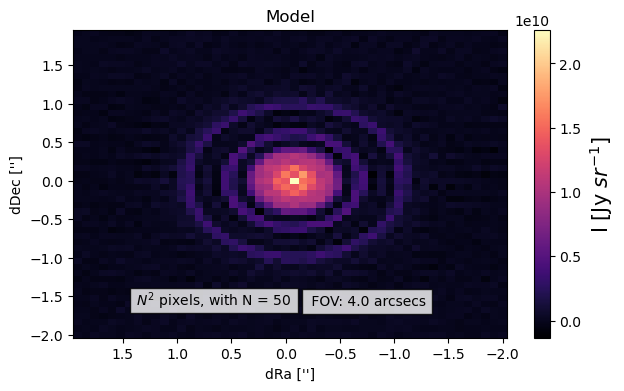

In [13]:
Plot(frank2d).get_image()

We need only the positive frequencies

##### option 1: u > 0

In [893]:
vis_sol_reduced = vis_sol[:, :FT._Ny //2+1]

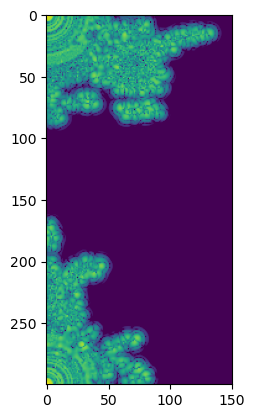

In [894]:
plt.imshow(np.log(np.abs(vis_sol_reduced.real)),vmin=-12, vmax=-2)

##### option 2: v > 0

In [645]:
vis_sol_reduced_2 = vis_sol[:FT._Ny //2, :]

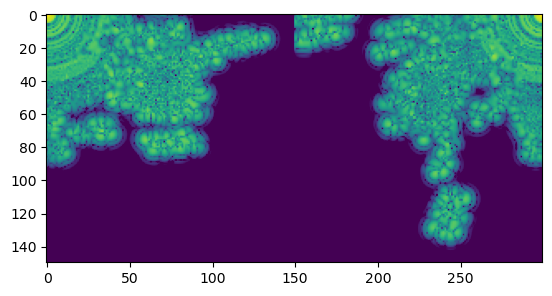

In [646]:
plt.imshow(np.log(np.abs(vis_sol_reduced_2.real)),vmin=-12, vmax=-2)

#### Let's reconstruct inmediatly the vis solution

In [588]:
vis_sol_reduced.shape

(300, 151)

##### from shifted scheme

In [573]:
vis_sol_reduced_shifted = np.fft.fftshift(vis_sol)[:, FT._Ny //2:]

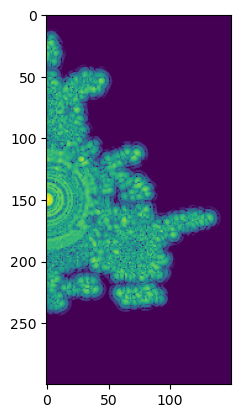

In [592]:
plt.imshow(np.log(np.abs(vis_sol_reduced_shifted.real)),vmin=-12, vmax=-2)

In [629]:
vis_full_shifted = np.zeros((FT._Nx, FT._Ny), dtype=complex)

vis_full_shifted[:, FT._Ny // 2:] = vis_sol_reduced_shifted.copy()

# constructing top-left panel
vis_full_shifted[1:(FT._Nx // 2-1), :FT._Ny // 2] = np.conj(
    np.flip(vis_sol_reduced_shifted[(FT._Nx//2+2):, :], axis=(0, 1))
)

# constructing bottom-left panel
vis_full_shifted[FT._Nx // 2-1:, :FT._Ny // 2] = np.conj(
    np.flip(vis_sol_reduced_shifted[1:FT._Nx // 2+2, :], axis=(0, 1))
)

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_62403/1244709547.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(vis_full_shifted.real)), extent = extent, vmin=-12, vmax=-2)


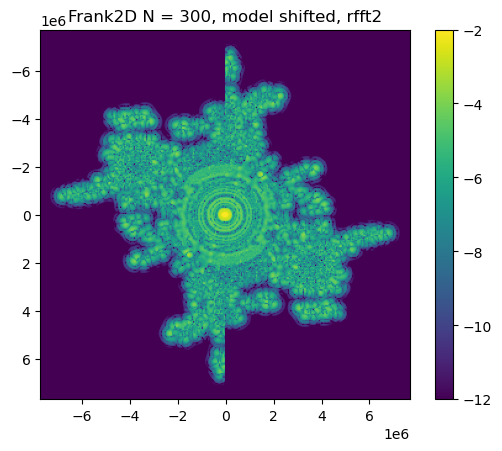

In [634]:
plt.clf()
plt.imshow(np.log(np.abs(vis_full_shifted.real)), extent = extent, vmin=-12, vmax=-2)
plt.title(F'Frank2D N = {N}, model shifted, rfft2')
plt.colorbar()

##### from unshifted scheme (doesn't work)

In [553]:
vis_sol_full = np.zeros((FT._Nx, FT._Ny), dtype=complex)

vis_sol_full[:, :FT._Ny // 2] = vis_sol_reduced.copy()

# Completar frecuencias negativas de v usando la simetría Hermitiana
for u_idx in range(FT._Nx):
    for v_idx in range(0, FT._Ny // 2): 
        if u_idx <= FT._Nx // 2:  # Cuadrante superior derecho
            vis_sol_full[u_idx, FT._Ny // 2 + v_idx] = np.conj(
                vis_sol_reduced[FT._Nx - 1 - u_idx, FT._Ny // 2 - 1 - v_idx]
            )
        else:  # Cuadrante inferior derecho
            vis_sol_full[u_idx, FT._Ny // 2 + v_idx] = np.conj(
                vis_sol_reduced[FT._Nx - u_idx, FT._Ny // 2 - 1- v_idx]
            )

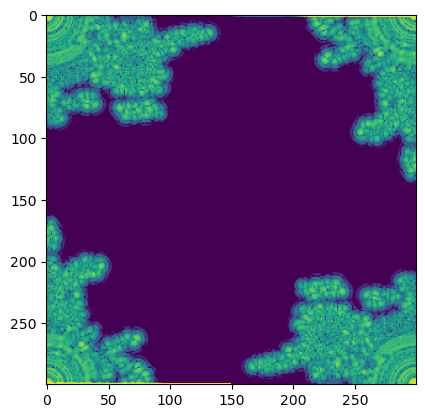

In [545]:
plt.clf()
plt.imshow(np.log(np.abs(vis_sol_full.real)),vmin=-12, vmax=-2)

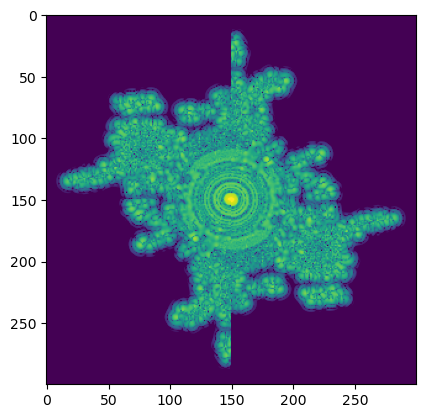

In [531]:
plt.clf()
plt.imshow(np.log(np.abs(np.fft.fftshift(vis_sol_full.real))),vmin=-12, vmax=-2)

#### We calculate intensity

##### option 1: u > 0

In [895]:
intensity_reduced = np.fft.fftshift(np.fft.irfft2(vis_sol_reduced, s=(FT._Nx, FT._Ny)))/(FT._dx * FT._dy)

In [896]:
frank2d.sol_intensity = intensity_reduced

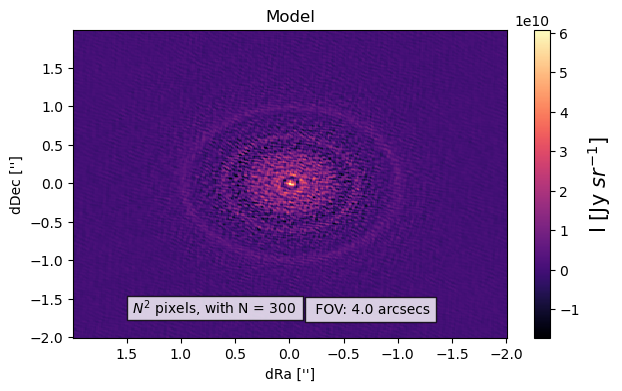

In [897]:
Plot(frank2d).get_image()

##### option 2: v>0

In [647]:
intensity_reduced_2 = np.fft.fftshift(np.fft.irfft2(vis_sol_reduced_2, s=(FT._Nx, FT._Ny)))/(FT._dx * FT._dy)

In [648]:
frank2d.sol_intensity = intensity_reduced_2

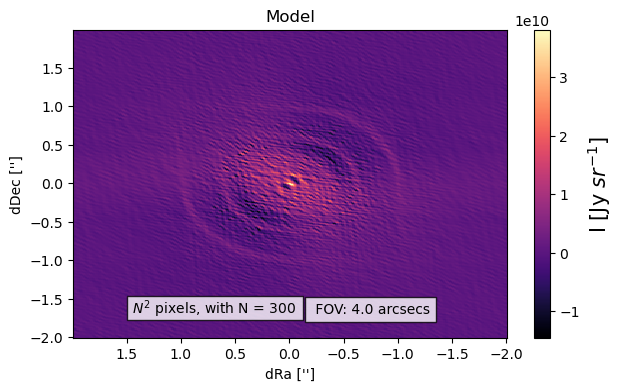

In [649]:
Plot(frank2d).get_image()

#### Let's try to calculate model visibilities using RFFT2

In [759]:
vis_reduced = np.fft.rfft2(intensity_reduced) * (FT._dx * FT._dy)

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_62403/886906327.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(vis_reduced.real)), vmin=-12, vmax=-2)


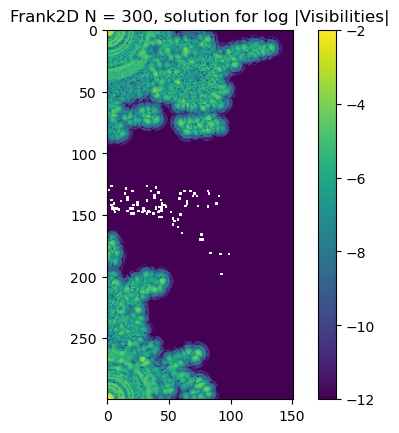

In [760]:
plt.imshow(np.log(np.abs(vis_reduced.real)), vmin=-12, vmax=-2)
plt.title(F'Frank2D N = {N}, solution for log |Visibilities|')
plt.colorbar()

In [761]:
vis_full_reconstructed = np.zeros((FT._Nx, FT._Ny), dtype=complex)

vis_full_reconstructed[:FT._Nx // 2, FT._Ny // 2:] = vis_reduced[FT._Nx // 2:,:-1]
vis_full_reconstructed[FT._Nx // 2:, FT._Ny // 2:] = vis_reduced[:FT._Nx // 2,:-1]

In [763]:
vis_full_reconstructed_right = vis_full_reconstructed[:, FT._Ny //2:]

In [765]:
# constructing top-left panel
vis_full_reconstructed[1:(FT._Nx // 2-1), :FT._Ny // 2] = np.conj(
    np.flip(vis_full_reconstructed_right[(FT._Nx//2+2):, :], axis=(0, 1))
)

# constructing bottom-left panel
vis_full_reconstructed[FT._Nx // 2-1:, :FT._Ny // 2] = np.conj(
    np.flip(vis_full_reconstructed_right[1:FT._Nx // 2+2, :], axis=(0, 1))
)

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_62403/1798957246.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(vis_full_reconstructed.real)), vmin=-12, vmax=-2)


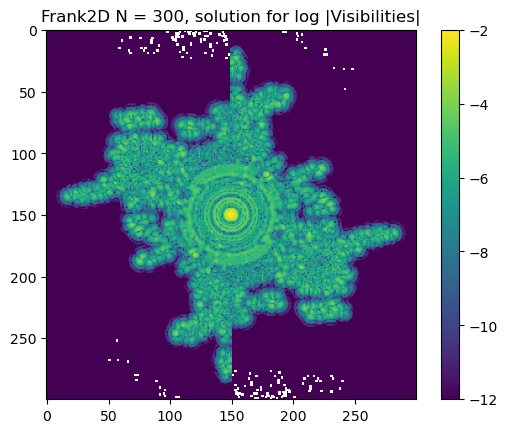

In [767]:
plt.clf()
plt.imshow(np.log(np.abs(vis_full_reconstructed.real)), vmin=-12, vmax=-2)
plt.title(F'Frank2D N = {N}, solution for log |Visibilities|')
plt.colorbar()

#### Imposing hermitian symmetry in visibilities considering all visibilities

In [858]:
def enforce_hermitian_symmetry_shifted(vis):
    N_x, N_y = vis.shape
    vis_symmetric = vis.copy()

    center_x, center_y = N_x // 2, N_y // 2

    for i in range(center_x, N_x):  # Recorrer la mitad derecha
        for j in range(N_y):   
            i_sym = (2 * center_x - i) % N_x
            j_sym = (2 * center_y - j) % N_y

            v_uv = vis_symmetric[i, j]
            v_neg_uv = vis_symmetric[i_sym, j_sym]

            if np.abs(v_neg_uv.real) > np.abs(v_uv.real):
                vis_symmetric[i, j] = np.conj(v_neg_uv)
            elif np.abs(v_neg_uv.real) < np.abs(v_uv.real):
                vis_symmetric[i_sym, j_sym] = np.conj(v_uv)
            else:
                vis_symmetric[i_sym, j_sym] = v_uv

    return vis_symmetric
vis_hermitian = enforce_hermitian_symmetry_shifted(np.fft.fftshift(vis_sol))

In [859]:
np.mean(vis_hermitian)

(0.00030650636040409124-3.440838428093869e-06j)

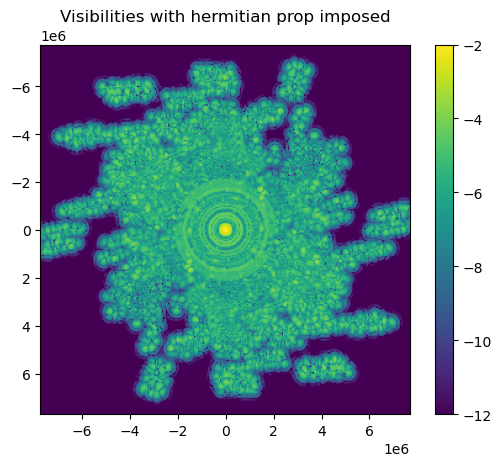

In [860]:
extent=[v_gridded.min(), v_gridded.max(), u_gridded.max(), u_gridded.min()]
plt.imshow(np.log(np.abs(vis_hermitian.real)),extent = extent, vmin=-12, vmax=-2)
plt.colorbar()
plt.title("Visibilities with hermitian prop imposed")
plt.show()

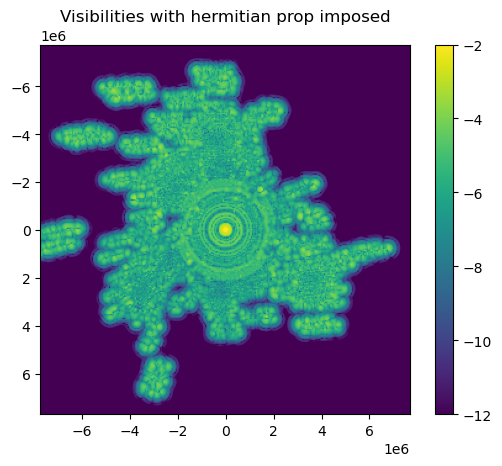

In [861]:
extent=[v_gridded.min(), v_gridded.max(), u_gridded.max(), u_gridded.min()]
plt.imshow(np.log(np.abs(np.fft.fftshift(vis_sol))),extent = extent, vmin=-12, vmax=-2)
plt.colorbar()
plt.title("Visibilities with hermitian prop imposed")
plt.show()

In [866]:
vis_hermitian_reduced = np.fft.fftshift(vis_hermitian)[:, :FT._Ny//2]
intensity_hermitian_reduced = np.fft.fftshift(np.fft.irfft2(vis_hermitian_reduced, s=(FT._Nx, FT._Ny)))/(FT._dx * FT._dy)

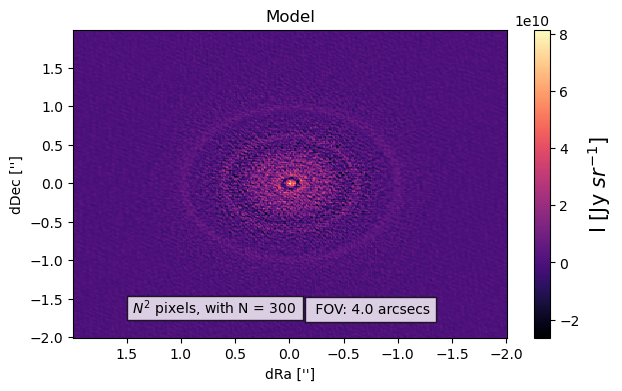

In [867]:
frank2d.sol_intensity = intensity_hermitian_reduced
Plot(frank2d).get_image()

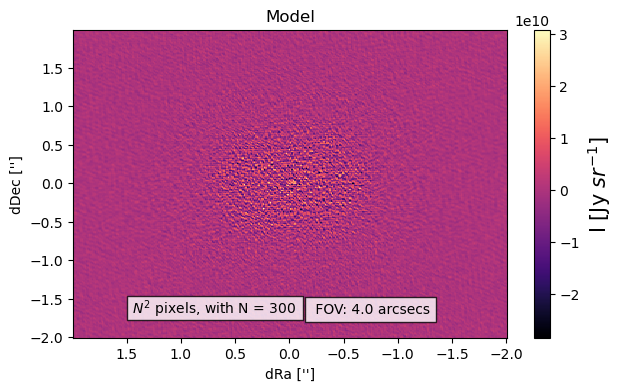

In [873]:
frank2d.sol_intensity = intensity_hermitian_reduced - intensity_reduced
Plot(frank2d).get_image()

# Let's see the original vis and intensity solution

In [14]:
FT = frank2d._FT
x_labels = np.fft.fftshift(FT._u/1e6)
y_labels = np.fft.fftshift(FT._v/1e6)

num_ticks = 5
x_ticks_to_show = np.linspace(0, len(x_labels) - 1, num_ticks).astype(int)
y_ticks_to_show = np.linspace(0, len(y_labels) - 1, num_ticks).astype(int)

def format_labels(x):
    return f"{int(x):d}" if abs(x) > 1e-8 else "0"

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_35402/2359072249.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(np.fft.fftshift(vis_gridded.reshape(frank2d._FT._Nx, frank2d._FT._Ny)))), origin='lower', vmin=-12, vmax=-2)


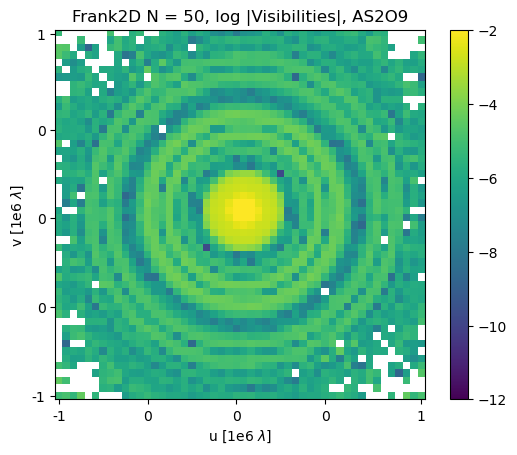

In [20]:
plt.imshow(np.log(np.abs(np.fft.fftshift(vis_gridded.reshape(frank2d._FT._Nx, frank2d._FT._Ny)))), origin='lower', vmin=-12, vmax=-2)
plt.xticks(ticks=x_ticks_to_show, labels=[format_labels(x) for x in np.array(x_labels)[x_ticks_to_show]])
plt.yticks(ticks=y_ticks_to_show, labels=[format_labels(y) for y in np.array(y_labels)[y_ticks_to_show]])
plt.xlabel(r'u [1e6 $\lambda$]')
plt.ylabel(r'v [1e6 $\lambda$]')
plt.title(F'Frank2D N = {N}, log |Visibilities|, AS2O9')
plt.colorbar()

### Comparing solutions

In [16]:
r, I = get_radial_profile(frank2d)

In [17]:
# Frank 1D Parameters
n_pts = 300
alpha = 1.3
w_smooth = 1e-1

geom = SourceGeometry(inc= inc, PA= pa, dRA= dra, dDec= ddec)
FF = FrankFitter(Rout, n_pts, geom, alpha = alpha, weights_smooth = w_smooth)
sol = FF.fit(u, v, Vis, Weights)

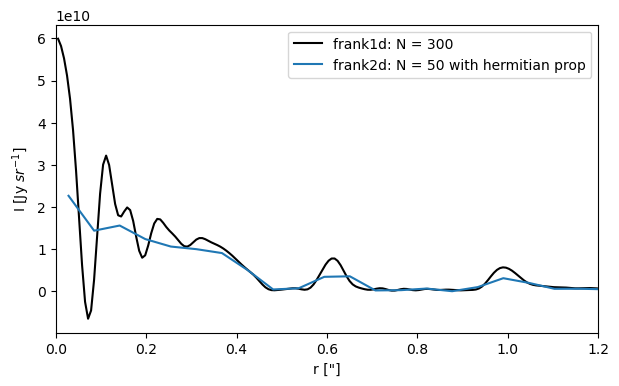

In [19]:
plt.figure(figsize=(7,4))
plt.plot(sol.r, sol.mean, 'black',label =f'frank1d: N = {n_pts}')
plt.plot(r, I, label = f'frank2d: N = {N} with hermitian prop')
#plt.plot(r2, I2, label = f'frank2d: N = {N} with hermitian prop imposed first')
plt.xlabel('r ["]')
plt.xlim(0, 1.2)           
plt.ylabel(r'I [Jy $sr^{-1}$]')
plt.legend()
#plt.yscale("log")
plt.show()

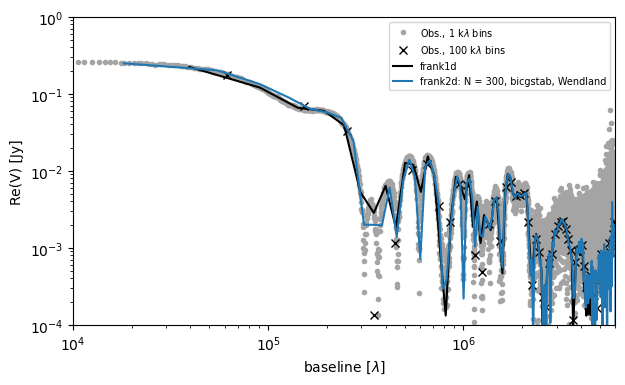

In [56]:
cs, ms = ['#a4a4a4', 'k'], ['.', 'x']
bin_widths=[1e3, 1e5]
baselines = np.hypot(u_deproj, v_deproj)         
grid = np.logspace(np.log10(min(baselines.min(), baselines[0])),
                           np.log10(max(baselines.max(), baselines[-1])),
                           10**4)

plt.figure(figsize=(7,4))

for i in range(len(bin_widths)):
            binned_vis = UVDataBinner(baselines, vis_deproj, Weights, bin_widths[i])
            plt.plot(binned_vis.uv, np.abs(binned_vis.V), c=cs[i],
                         marker=ms[i], ls='None', 
                         label=r'Obs., {:.0f} k$\lambda$ bins'.format(bin_widths[i]/1e3))


#frank1d
vis_fit_1d = sol.predict_deprojected(sol.q)
baselines_fit_1d = sol.q
plt.plot(baselines_fit_1d, np.abs(vis_fit_1d), color = "black", label = r'frank1d')

#frank2d
q, Vis_1= get_vis_profile(frank2d)
plt.plot(q, np.abs(Vis_1.real), label = f'frank2d: N = {N}, bicgstab, Wendland')

plt.xlabel(r'baseline [$\lambda$]')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-4, 1)
plt.xlim(1e4, 6e6)
plt.ylabel('Re(V) [Jy]', size = 10)
plt.legend(fontsize =7)
plt.show()

### Comparing with CLEAN

In [311]:
# Obtain the radial profiles convolved to a circular beam.
from gofish import imagecube

infile_1mm = dir + 'AS209_1mm_13s_conv_circ.fits'
#2D->1D
cube_1mm = imagecube(infile_1mm)
x_1mm,y_1mm,dy_1mm = cube_1mm.radial_profile(inc=inc, PA=pa, x0=dra, y0=ddec)

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


In [312]:
from frank.utilities import convolve_profile

clean_beam_1mm = {'bmaj':0.0373, 'bmin':0.0373, 'beam_pa':31.040}
area_1mm = clean_beam_1mm['bmaj']*clean_beam_1mm['bmin']*np.pi/4./np.log(2.)*(1/rad_to_arcsec)**2

convolved_1mm_frank2d = convolve_profile(r, I, inc, pa, clean_beam_1mm)*area_1mm
convolved_1mm_frank1d = convolve_profile(sol.r, sol.mean, inc, pa, clean_beam_1mm)*area_1mm

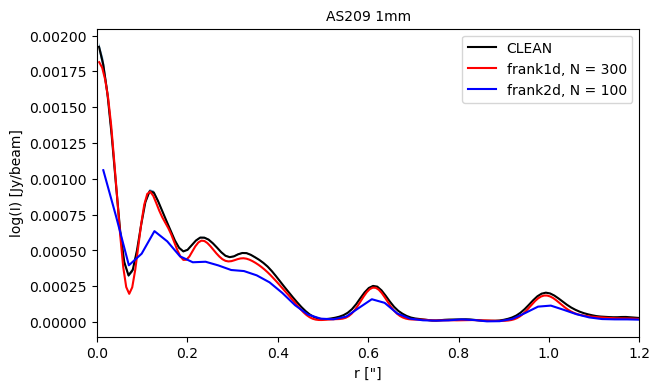

In [313]:
plt.figure(figsize=(7, 4))
plt.plot(x_1mm, y_1mm, "black", label = "CLEAN")
plt.fill_between(x_1mm, y_1mm-dy_1mm, y_1mm+dy_1mm,alpha=0.7)
plt.plot(sol.r, convolved_1mm_frank1d, "red", label=r'frank1d' + ', N = ' +str(n_pts))
plt.plot(r,convolved_1mm_frank2d, "blue", label=r'frank2d' + ', N = ' +str(N))
plt.title(r'AS209 1mm', size=10)
plt.ylabel("log(I) [Jy/beam]", size=10)
plt.xlabel('r ["]', size=10)
plt.legend(fontsize=10)
#plt.yscale('log')
#plt.ylim(0.1e-5, 0.5e-2)
plt.xlim(0,1.2)
plt.show()